<a href="https://colab.research.google.com/github/yaobviously/DataCup2021/blob/main/hockeygoalmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
!pip install category_encoders --quiet
!pip install shap --quiet
!pip install pdpbox --quiet

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import datetime
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import roc_curve


URL = 'https://raw.githubusercontent.com/yaobviously/DataCup2021/main/modifiedohl.csv'

In [77]:
def wrangle(URL):
  df = pd.read_csv(URL,
                   parse_dates = ['game_date'],
                   index_col = 'game_date')
  
  # dropping columns i made awhile ago that i don't need to build models, 
  # although they may be handy for communicating insights. all of the score
  # and player differentials can now, i see, be reduced to single columns for
  # the purposes of model building

  col_drop = ['Unnamed: 0', 'possSet', 'shots_next_ten', 'goal_next_ten', 
              '5on5', '5on4home', '5on3home', '5on4away', '5on3away', 
              '4on4', 'tie', 'home_ahead_1', 'home_ahead_2', 'home_ahead_3ormore',
              'away_ahead_1', 'away_ahead_2', 'away_ahead_3ormore', 'home_team',
              'away_team', 'x_coordinate_2', 'y_coordinate_2', 'detail_2',
              'player_2']

  df = df.drop(columns = col_drop).copy()
  df = df.rename(columns = {'detail_3' : 'traffic', 'detail_4' : 'one_timer',
                            'detail_1' : 'shot_type'})
  
  # condensing the above columns: i do not need separate columns for each 
  # man-advantage state

  df['home_skater_adv'] = df['home_team_skaters'] - df['away_team_skaters']
  df['home_score_diff'] = df['home_team_goals'] - df['away_team_goals']
  df['is_shot'] = [1 if event in ['Goal', 'Shot'] else 0 for event in df['event']]

  # converting the clock column to the seconds remaining in the period in the
  # ugliest way imaginable
  
  df['min'] = df.clock.apply(lambda x: datetime.datetime.strptime(x,'%M:%S')).dt.minute
  df['sec'] = df.clock.apply(lambda x: datetime.datetime.strptime(x, '%M:%S')).dt.second
  df['period_sec_rem'] = df['min'] * 60 + df['sec']
  
  df.drop(columns = 'clock', inplace = True)

  # calculating the seconds remaining in the game, mostly for practice (needed!)

  def gamesecs(x):
  
    if x['period'] == 1:
      return x['period_sec_rem'] + 2400

    if x['period'] == 2:
      return x['period_sec_rem'] + 1200
  
    else:
      return x['period_sec_rem']

  df['game_sec_rem'] = df.apply(gamesecs, axis = 1)

  # creating new columns that contain info on prior game states

  df['x_coordinate_1back'] = df['x_coordinate'].shift()
  df['y_coordinate_1back'] = df['y_coordinate'].shift()
  df['x_coordinate_2back'] = df['x_coordinate'].shift(2)
  df['y_coordinate_2back'] = df['y_coordinate'].shift(2)
  df['event_1back'] = df['event'].shift()
  df['event_2back'] = df['event'].shift(2)

  df['sec_last_event'] = np.abs(df.groupby(['gameid', 'period'])['period_sec_rem'].diff())
  df['sec_2ndlast_event'] = np.abs(df.groupby(['gameid', 'period'])['period_sec_rem'].diff(2))

  # dropping redundant and leaky columns. note 'event' may be useful for
  # finding and creating useful (and non-leaky) features
  
  df.drop(columns = ['min', 'sec', 'event'], inplace = True)

  # dropping columns with negligible importance. note 'team' & 'period may be 
  # useful for finding and creating useful (and non-leaky) features.

  lowimp_columns = ['away_team_goals', 'home_team_goals', 
                    'home_score_diff', 'home_team_skaters',
                    'away_team_skaters', 'traffic', 'event_2back',
                    'team', 'game_sec_rem', 'period', 'gameid', 'player']

  

  df.drop(lowimp_columns, axis = 1, inplace = True)
  

  return df

In [78]:
df = wrangle(URL)


In [79]:
# shrink the dataframe down to include only rows where a shot occurred. 

df_shots = df[df['is_shot'] == 1]
df_shots = df_shots.drop(columns = 'is_shot')


In [80]:
# calculating the baseline frequency of a goal conditional on a shot being taken

baseline_frequency = df_shots['is_goal'].value_counts(normalize = True).max()
print(baseline_frequency)

0.9434362934362934


In [81]:
# Separating the data into train, validation, and test sets using dates. I do not 
# want to separate them using index values because games should be treated as separate
# events.

target = 'is_goal'

train_threshold = '2020-01-15'
test_threshold = '2020-02-13'

mask = df_shots.index < train_threshold
mask2 = df_shots.index > test_threshold

X = df_shots.drop(target, axis = 1)
y = df_shots[target]

X_train, y_train = X[mask], y[mask]
X_val, y_val = X[~mask & ~mask2], y[~mask & ~mask2]
X_test, y_test = X[mask2], y[mask2]

In [69]:
# Building and fitting the LogisticRegression model. i added a standardscaler 
# because this is a linear model and i changed the class weight,  penalty, and 
# solver to enable 

model_lr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(class_weight = 'balanced',
                       penalty = 'elasticnet',
                       solver = 'saga',
                       l1_ratio = 0.1)
    
  
)
model_lr.fit(X_train, y_train);

In [82]:
# tuning the logistic regression model. i chose not to print the values, but the
# optimal l1 penalty is 1.

l1s = [n for n in np.arange(0.1,1,0.1)]
train_scores = []
val_scores = []

for l in l1s:
  
  model_lr = make_pipeline(
     OrdinalEncoder(),
     SimpleImputer(),
     StandardScaler(),
     LogisticRegression(class_weight = 'balanced',
                        penalty = 'elasticnet',
                        solver = 'saga',
                        l1_ratio = l)
    
  
  )
  model_lr.fit(X_train, y_train)
  tscore_ = model_lr.score(X_train, y_train)
  vscore_ = model_lr.score(X_train, y_train)
  train_scores.append(tscore_)
  val_scores.append(vscore_);

In [ ]:
# extracting and displaying the coefficients of the logistic regression model

lr_features = model_lr.named_steps['ordinalencoder'].get_feature_names()
lr_coefficients = (model_lr.named_steps['logisticregression'].coef_).ravel()

pd.Series(lr_coefficients, index = lr_features).sort_values().plot.barh()
plt.title('Coefficients for the Logistic Regression Model')
plt.xlabel('Coefficient Weight')
plt.ylabel('Feature')
plt.show();

In [84]:
# Building and fitting a RandomForestClassifier

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(max_depth = 18,
                           class_weight = 'balanced_subsample',
                           criterion = 'entropy',
                           min_samples_split = 4)

)
model_rf.fit(X_train, y_train);

In [ ]:
# Optimizing the RandomForestClassifier

param_grid = {
    'randomforestclassifier__max_depth' : [n for n in np.arange(4,20,2)],
    'randomforestclassifier__criterion' : ['gini', 'entropy'],
    'randomforestclassifier__min_samples_split': [2, 4, 8]
}

rf_search = RandomizedSearchCV(model_rf, param_distributions = param_grid,
                               scoring = 'roc_auc')

rf_search.fit(X_train, y_train)

print('The best score achieved by the RF model is:', rf_search.best_score_)
print('The best paramaters for the RF model were:', rf_search.best_params_)

The best score achieved by the RF model is: 0.7809870143758493
The best paramaters for the RF model were: {'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__max_depth': 18, 'randomforestclassifier__criterion': 'entropy'}


In [85]:
# Building and training an XGBClassifier model. The eval_metric parameter was set to
# AUC, which will optimize other parameters in the model to achieve higher AUC scores

model_xg = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(eval_metric = 'auc')
)

model_xg.fit(X_train, y_train);

In [ ]:
# Printing the classification report and displaying the confusion matrix for the
# XGBoostClassifier

print(classification_report(y_test, model_xg.predict(X_test)))
plot_confusion_matrix(model_xg, X_test, y_test, values_format = '.0f');

In [ ]:
# Plotting the linear versus the tree models using the plot_roc_curve function

plot_roc_curve(model_lr, X_test, y_test, c = 'r')
plot_roc_curve(model_rf, X_test, y_test, c = 'purple')
plot_roc_curve(model_xg, X_test, y_test);

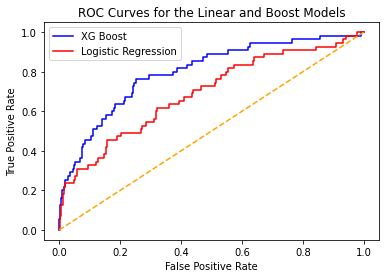

In [88]:
# Creating a ROC Curve (for the test set) manually with matplotlib using the parameters 
# extracted using roc_curve. I like the dashed orange line. 

y_predxg = model_xg.predict_proba(X_test)[:,1]
y_predlr = model_lr.predict_proba(X_test)[:,1]

fp, tp, thresh = roc_curve(y_test, y_predxg)
fpgb, tpgb, threshgb = roc_curve(y_test, y_predlr)

plt.plot(fp, tp, c = 'b', label = 'XG Boost')
plt.plot(fpgb, tpgb, c = 'red', label = 'Logistic Regression')
plt.plot([0,1], c = 'orange', ls = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for the Linear and Boost Models')
plt.legend(loc = 'best')
plt.show();

In [ ]:
# Extracting and plotting the feature importances for the RandomForestClassifier

features = model_rf.named_steps['ordinalencoder'].get_feature_names()
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_


feature_importances = pd.DataFrame(importances, index = features).plot.barh()
plt.title('Random Forest Model Feature Importances')
plt.legend('')
plt.show();

In [ ]:
# Extracting and plotting the feature importances for the XGBoostClassifier

features = model_xg.named_steps['ordinalencoder'].get_feature_names()
xg_importances = model_xg.named_steps['xgbclassifier'].feature_importances_

xg_feature_importances = pd.DataFrame(xg_importances, index = features).plot.barh()
plt.title('XGBoost Model Feature Importances')
plt.legend('')
plt.savefig('XGfeatures.png')
plt.show();

In [ ]:
# Calculating permutation importance for the XGBoost Classifier using sklearn 
# and putting the output means and stds into a DataFrame. I left y_coordinate 
# 2back in because it is paired with the x_coordinate 2back. 

perm_imp = permutation_importance(model_xg, X_test, y_test, n_repeats = 5, scoring = 'roc_auc')

perm_dict = {
    'perm_mean' : perm_imp['importances_mean'],
    'perm_std' : perm_imp['importances_std']
}

perm_df = pd.DataFrame(perm_dict, index = X.columns).sort_values(by = 'perm_mean', ascending = False)

perm_df['normed_importance'] = (perm_df['perm_mean'] / perm_df['perm_mean'].sum()).round(4)
perm_df

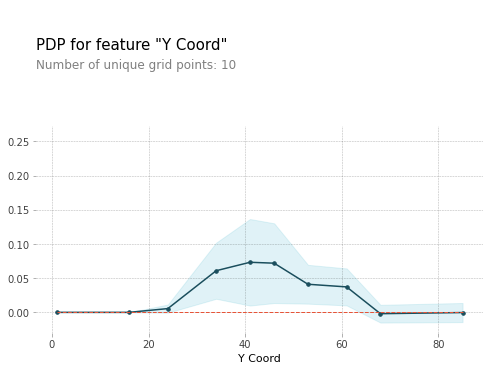

In [90]:
# Creating a partial dependence plot for the XGBoost Classifier

encoder = OrdinalEncoder()
imputer = SimpleImputer()

X_val_encoded = encoder.fit_transform(X_val)
X_valenc_imputed = imputer.fit_transform(X_val_encoded)

X_val_pdp = pd.DataFrame(X_valenc_imputed, columns = X_val.columns)


hockey_pdp = pdp_isolate(model_xg,
                         X_val_pdp,
                         model_features = X.columns,
                         feature = 'y_coordinate')

fig, ax = pdp_plot(hockey_pdp,
                   feature_name = 'Y Coord',
                   figsize = (8,6),
                   plot_params = {'fontfamily' : 'DejaVu Sans'}
                   )

plt.show();

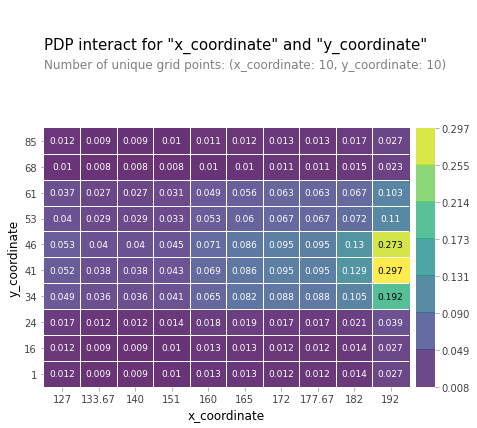

In [91]:
# A simple function that returns a partial dependent interaction plot for the features
# you enter into it. practice. in reality, only x_coordinate and y_coordinate are
# especially informative when graphed. note that the shots locations with the highest probability
# of going in are, of course, right in front of the net! also note that in this plot
# the x_coordinate only extends to roughly the blue line (the offensive zone)

def pdpinteract(feature1, feature2):

  features_pdp_int = [feature1, feature2]

  x_y_interact = pdp_interact(model_xg,
                            dataset = X_val_pdp,
                            model_features = X_val_pdp.columns,
                            features = features_pdp_int)

  x_y_int_plot = pdp_interact_plot(x_y_interact,
                                 plot_type = 'grid',
                                 feature_names = features_pdp_int,
                                 figsize = (7,7),
                                 plot_params = {'fontsamily' : 'DejaVu Sans'})
  
  return x_y_int_plot

pdpinteract('x_coordinate', 'y_coordinate');

In [92]:
# Creating Shapley plots

# First, creating and training a new model that's legible to SHAP
shap_encoder = OrdinalEncoder()
shap_imputer = SimpleImputer()

xg_encoded = encoder.fit_transform(X_train)
X_trainxg_imputed = imputer.fit_transform(xg_encoded)

shap_model = XGBClassifier(eval_method = 'auc')

shap_model.fit(X_trainxg_imputed, y_train)

# Converting the validation set to a format that's legible to SHAP and then
# creating an explainer and extracting the shap values

SHAP_val_encoded = shap_encoder.fit_transform(X_val)
SHAP_val_imputed = shap_imputer.fit_transform(SHAP_val_encoded)
SHAP_val_df = pd.DataFrame(SHAP_val_imputed, columns = X_val.columns)

explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(SHAP_val_imputed)

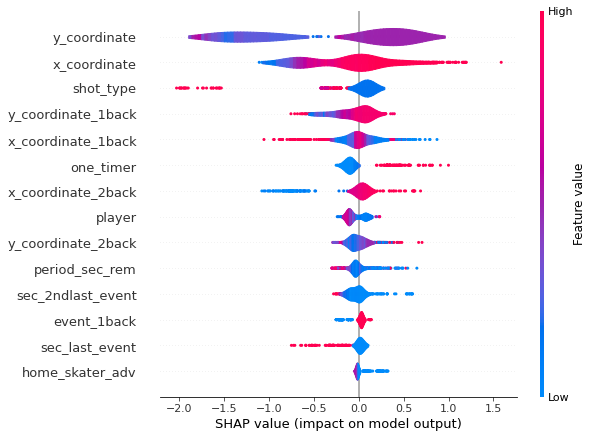

<Figure size 432x288 with 0 Axes>

In [ ]:
# plotting the SHAP value summary for the XGBoost model on the validation 
# set

shap.summary_plot(shap_values,
                  SHAP_val_df,
                  plot_type = 'violin')


plt.savefig("summary_plot.png");

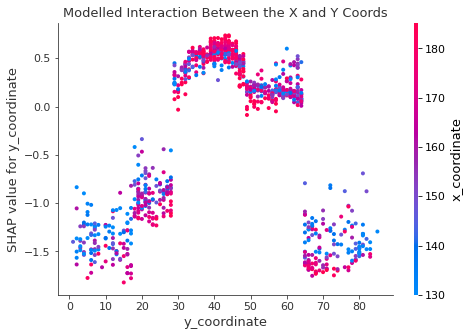

In [ ]:
# Creating a SHAP dependence plot for the x_coordinate and y_coordinate. You can see
# here that shots to the left of the center of the net are slightly better. You can also
# discern that shots at a sharper angle are less likely to go in even if they're closer!
# Note also that it has the same general shape as the PDP plot above.

sh = shap.dependence_plot('y_coordinate',
                          shap_values,
                          SHAP_val_df,
                          interaction_index = 'x_coordinate',
                          title = 'Modelled Interaction Between the X and Y Coords',
                          show = False)

plt.xticks(np.arange(0,90,10))

plt.ylabel('SHAP value for y_coordinate')
plt.xlabel('y_coordinate')
plt.savefig('dependence_plot.png')

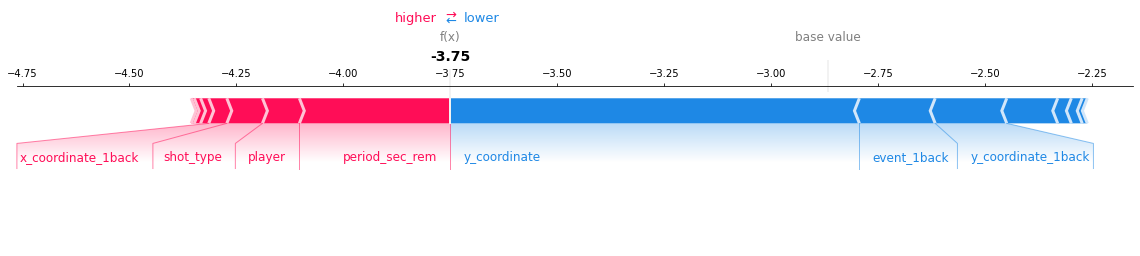

In [ ]:
# Here I create a force plot. First I have to initialize java script. The force
# plot shows how the effect on the model predictions changes as features vary. 
# One especially illustrative example is: 
# 
# Sample Order by Output Value 
#
# and
#
# y_coordinate effects

# shap.initjs()

# shap.force_plot(explainer.expected_value,
#                 shap_values,
#                 features = X.columns,
#                 matplotlib = True)

# The code below creates a force plot for a particular observation, since that's
# a lot simpler and doesn't require javascript!

shap.force_plot(explainer.expected_value,
                shap_values[0,:],
                X.columns,
                plot_cmap=["#FF5733","#335BFF"],
                matplotlib = True)